In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# load the data
data = pd.read_csv('games.csv')

In [3]:
# data overview
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.shape

(16715, 11)

### Подготовка данных

#### Приведение названий колонок к нижнему регистру

In [5]:
# lowercase for column names
data.columns = data.columns.str.lower()

In [6]:
# checking dtypes
data.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

#### Преобразование типов и обработка пропусков:
name, platform, genre, rating имеют строковый тип(object) - OK   
user_score так же имеет строковый тип - необходимо конвертировать в float и обработать 'tbd'(to be declared - неизвестный рейтинг)          
na_sales, eu_sales, jp_sales, other_sales, critic_score - float type - OK  
year_of_release лучше привести к типу int


In [7]:
# filling tbd with NaN 
data.loc[(data.user_score == 'tbd'), 'user_score'] = np.nan

In [8]:
# casting user_score to float 
data.user_score = data.user_score.astype(float)

В колонке user_score был заменен тип данных со строкового на числовой, т.к. в этой колонке содержатся числовые данные

In [9]:
# checking for NaN
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [10]:
# filling year from name 
year = pd.DataFrame(data.name.str.extract(r'.*([1-3][0-9]{3})'))
data.year_of_release.fillna(year[0], inplace=True)
data.year_of_release = data.year_of_release.apply(lambda x: float(x))

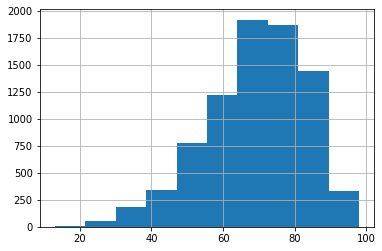

In [11]:
# distribution of critic score
data.critic_score.hist()

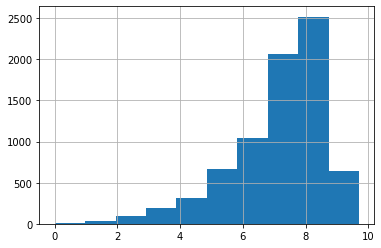

In [12]:
# distribution of user_score
data.user_score.hist()

В колонках user_score и critic_score много пропущенных значений, можно заполнить их медианой по названию игры или жанру, маркерным значением или оставить как есть(так как мы не строим модель машинного обучения).
А в данном случае я выбрала маркер -1, т.к. для графиков и расчетов их можно будет отсечь по этому значению.
Рейтинг с неизвестными значениями выделен в отдельную категорию 'other'.

In [13]:
# imputing missing values
data.loc[(data.rating.isna() == True), 'rating'] = 'other'
data.loc[(data.user_score.isna() == True), 'user_score'] = -1
data.loc[(data.critic_score.isna() == True), 'critic_score'] = -1

Строк с незаполненными значениями осталось не так много - можно от них избавиться.

In [14]:
#data = data.dropna()
data.isna().sum().sum()

256

In [15]:
# dropping rows with NaN 
data = data.dropna()

In [16]:
# cast year to int
data.year_of_release = data.year_of_release.apply(lambda x: int(x))

Создание колонки для суммарных продаж по всем регионам

In [17]:
# summary sales
data['sum_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

### EDA

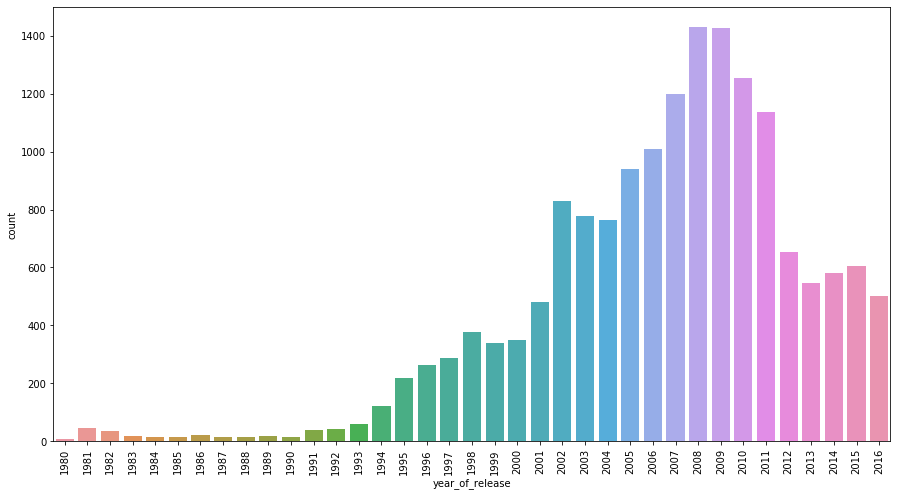

In [18]:
plt.figure(figsize=(15,8))
ax = sns.countplot(data=data, x='year_of_release')
plt.xticks(rotation='vertical');

Значимые годы по количеству выпускаемых игр - с 2000 по 2016

In [19]:
# choose 6 top platforms 
platforms = data.groupby(['platform'])['sum_sales'].agg('sum').sort_values(ascending=False).head(6).index.tolist()
platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

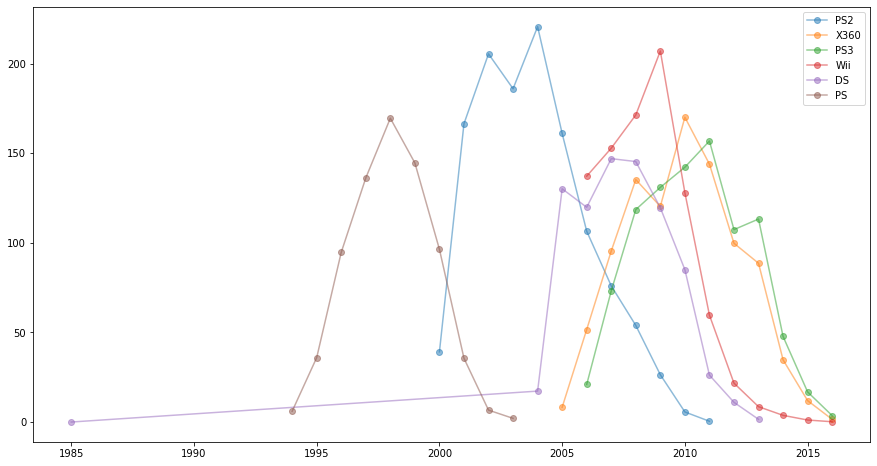

In [20]:
# distribution by platforms
plt.figure(figsize=(15,8))
for plat in platforms:
    plat_data = data[data['platform'] == plat].groupby(['year_of_release'])['sum_sales'].agg('sum').reset_index()
    plt.plot(plat_data['year_of_release'], plat_data['sum_sales'], '-o', label=plat, alpha=0.5)
    plt.legend()

В среднем платформы популярны около 10 лет

Отсечем года до 2005

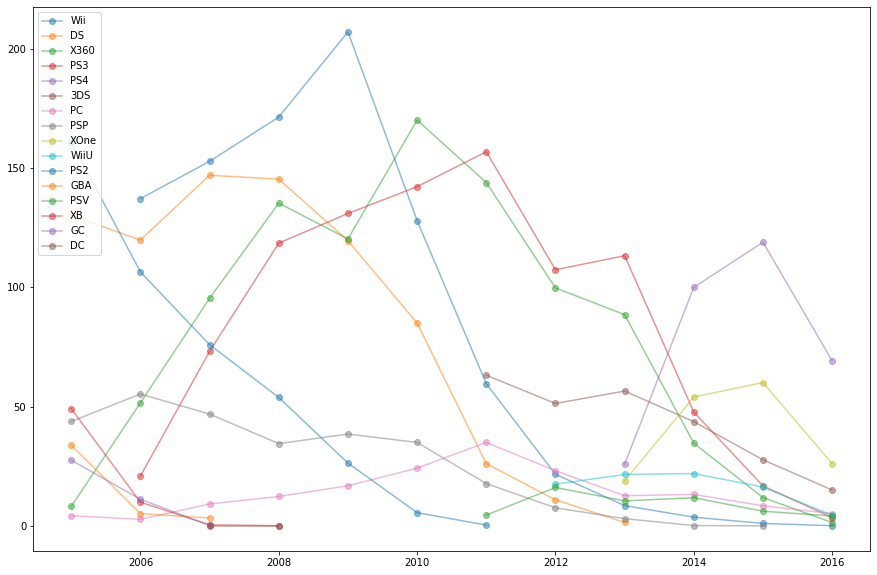

In [21]:
# year threshold
data = data[data['year_of_release'] >= 2005]
# distribution by platforms
plt.figure(figsize=(15,10))
for plat in data['platform'].unique():
    plat_data = data[data['platform'] == plat].groupby(['year_of_release'])['sum_sales'].agg('sum').reset_index()
    plt.plot(plat_data['year_of_release'], plat_data['sum_sales'], '-o', label=plat, alpha=0.5)
    plt.legend(loc='upper left')

По графику создается впечатление, что наблюдается отрицательный тренд по всем платформам

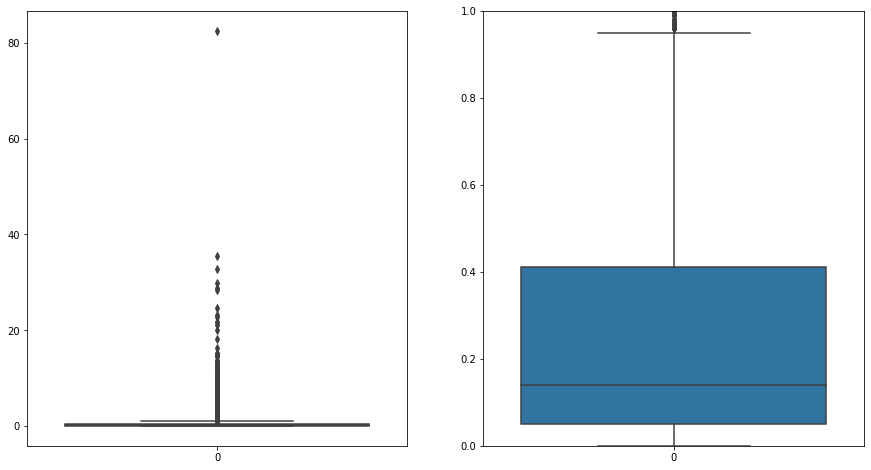

In [22]:
# plotting sales by platform
fig, axes = plt.subplots(figsize=(15,8))
ax = plt.subplot(1, 2, 1)
sns.boxplot(data=data['sum_sales']);
ax = plt.subplot(1, 2, 2)
sns.boxplot(data=data['sum_sales']);
ax.set_ylim([0,1])
plt.show()

Суммарные данные о продажах имеют много выбросов, поэтому удобнее задать лимит по оси y. Медиана составляет примерно 0.15 млн, межквартильный размах от 0.1 до 0.4.

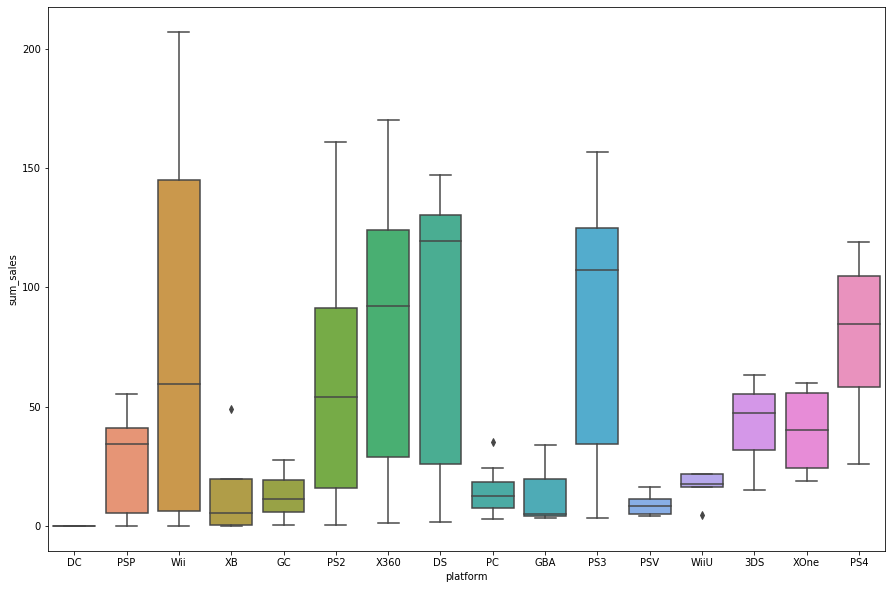

In [23]:
# plotting sales by platform
plt.figure(figsize=(15,10))
plat_data = data.groupby(['year_of_release', 'platform'])['sum_sales'].agg('sum').sort_values().reset_index()
sns.boxplot(x='platform', y='sum_sales', data=plat_data);

Медиана продаж выше всего у платформ: DS, PS3, X360  
Самые низкие показатели у платформы DS 
Самая высокая верхняя граница - Wii, а у WiiU имеются выбросы ниже минимальной границы

Пользовательский рейтинг по платформе PS4

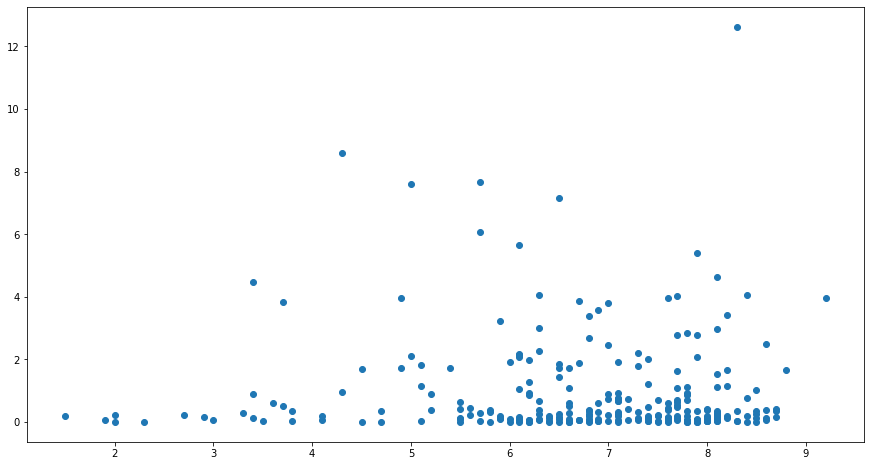

In [24]:
plt.figure(figsize=(15,8))
plt.scatter(x='user_score', y='sum_sales', data=data[(data['platform'] == 'PS4') & (data['user_score'] > 0)]);

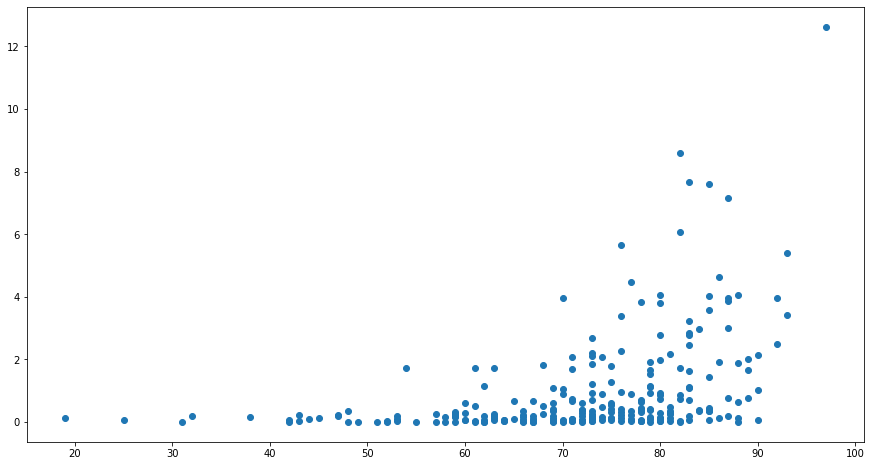

In [25]:
plt.figure(figsize=(15,8))
plt.scatter(x='critic_score', y='sum_sales', data=data[(data['platform'] == 'PS4') & (data['critic_score'] > 0)])

In [26]:
# for ps4
data_ps4 = data[data['platform'] == 'PS4']
critic_corr = data_ps4[data_ps4['critic_score'] > 0]['critic_score'].corr(data_ps4['sum_sales'])
user_corr = data_ps4[data_ps4['user_score'] > 0]['user_score'].corr(data_ps4['sum_sales'])
print(f'Корреляция оценки критиков и продаж для платформы PS4: {critic_corr:.2f}')
print(f'Корреляция оценки пользователей и продаж для платформы PS4: {user_corr:.2f}')

Корреляция оценки критиков и продаж для платформы PS4: 0.41
Корреляция оценки пользователей и продаж для платформы PS4: -0.03


In [27]:
# average
critic_corr = data[data['critic_score'] > 0]['critic_score'].corr(data['sum_sales'])
user_corr = data[data['user_score'] > 0]['user_score'].corr(data['sum_sales'])
print(f'Средняя корреляция оценки критиков и продаж:{critic_corr:.2f}')
print(f'Средняя корреляция оценки пользователей и продаж:{user_corr:.2f}')


Средняя корреляция оценки критиков и продаж:0.23
Средняя корреляция оценки пользователей и продаж:0.08


Таким образом зависимость продаж от оценки критиков очевидна, что нельзя сказать об оценке пользователей - она имеет субъективный характер.

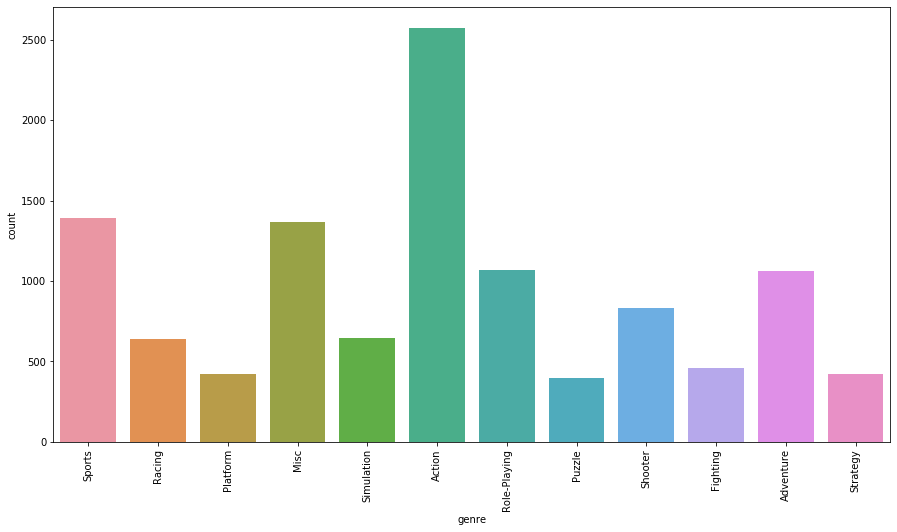

In [28]:
# release by genre
plt.figure(figsize=(15,8))
ax = sns.countplot(x=data['genre'])
plt.xticks(rotation='vertical');

Самые популярные жанры по количеству выпускаемых игр - Action, Sports и Misc.

In [29]:
# dictionary for regions
region_sales = {'sum_sales':'Summary sales', 'na_sales':'North America', 'eu_sales':'Europe', 'jp_sales':'Japan'}

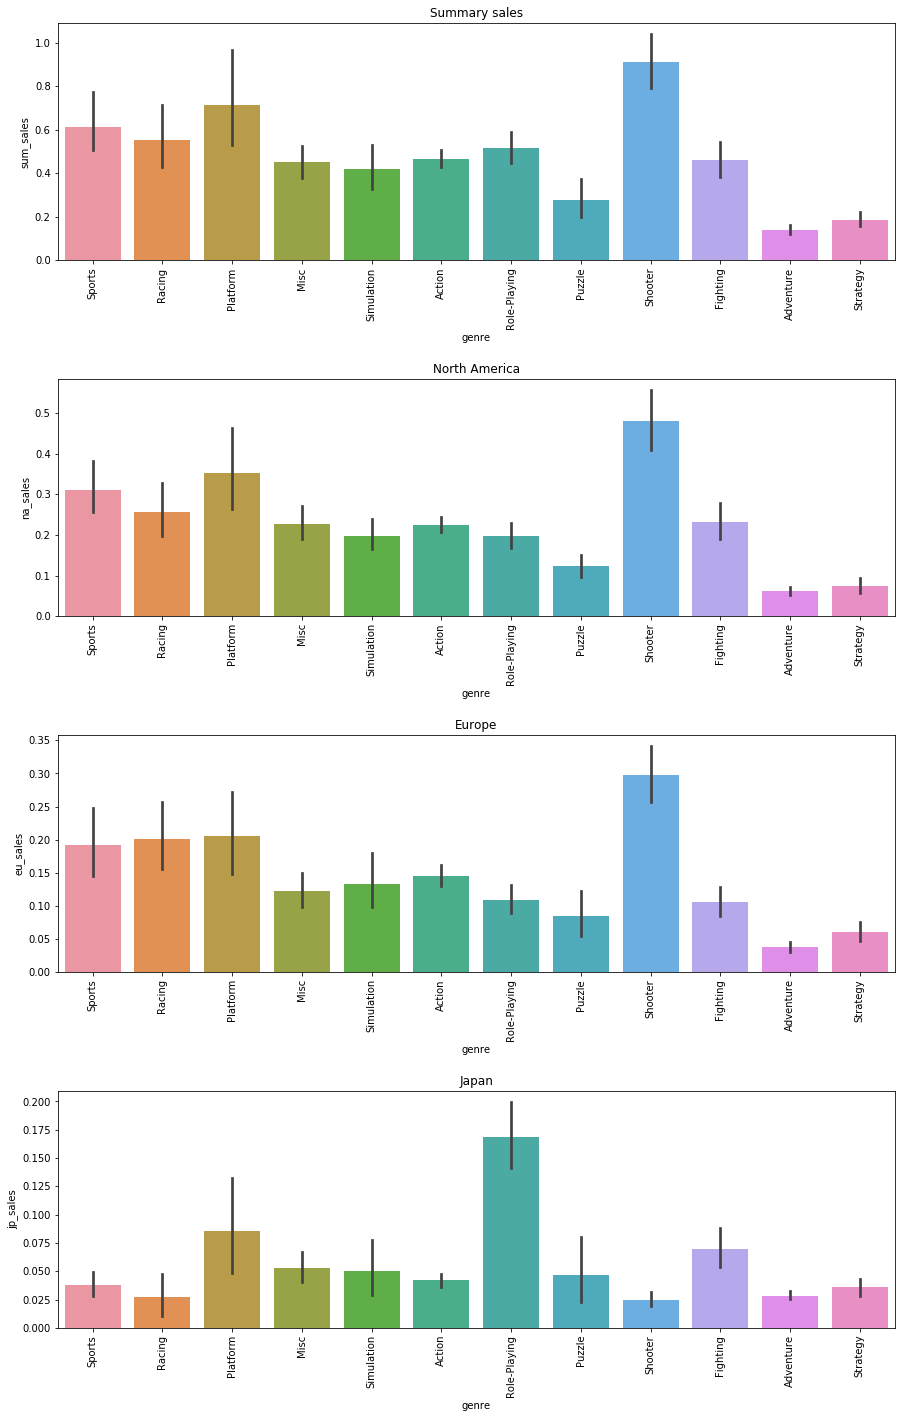

In [30]:
# sales by genre
plt.figure(figsize=(15,24))
plt.subplots_adjust(wspace=5, hspace=0.5)
a = 4  # number of rows
b = 1  # number of columns
c = 1  # initialize plot counter

for reg in region_sales.keys(): 
    ax = plt.subplot(a, b, c)
    sns.barplot(x=data['genre'], y=data[reg])
    plt.xticks(rotation='vertical');
    plt.title(region_sales[reg])
    c += 1


Самый популярный жанр по продажам как суммарно, так и в Америке и Европе - Shooter, однако в Японии предпочитают Role-Playing

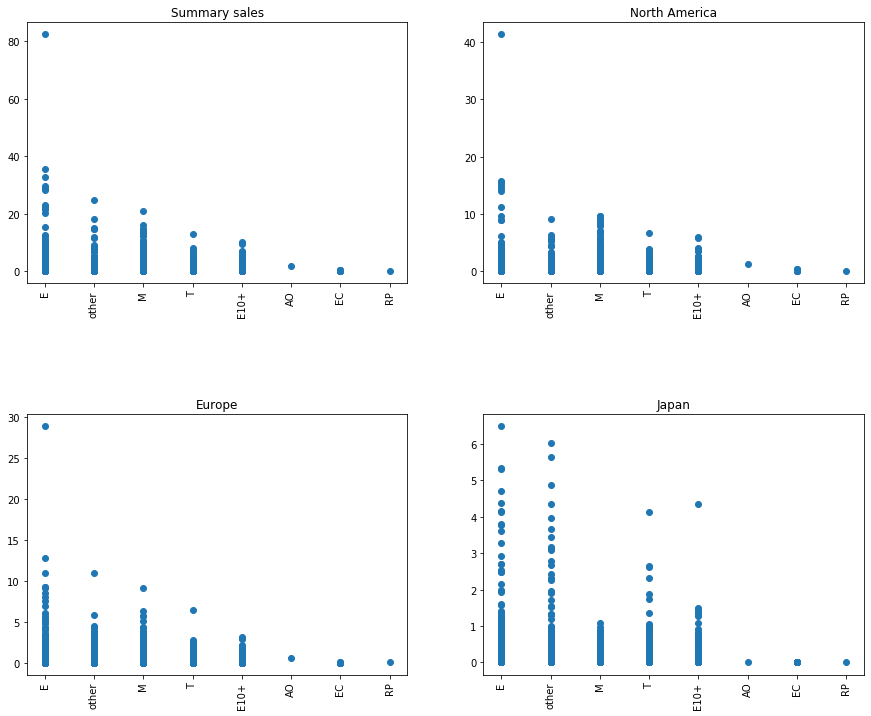

In [31]:
# region sales vs rating
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=0.5)
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

for reg in region_sales.keys(): 
    ax = plt.subplot(a, b, c)
    plt.scatter(x='rating', y=reg, data=data)
    plt.xticks(rotation='vertical');
    plt.title(region_sales[reg])
    c += 1


Максимальные продажи у игр с рейтингом E(для всех), по всем регионам, но в Японии так же достаточно много продается игр с рейтингом T(teenagers).

In [32]:
# list of genres for visualization
genres = data['genre'].unique().tolist()

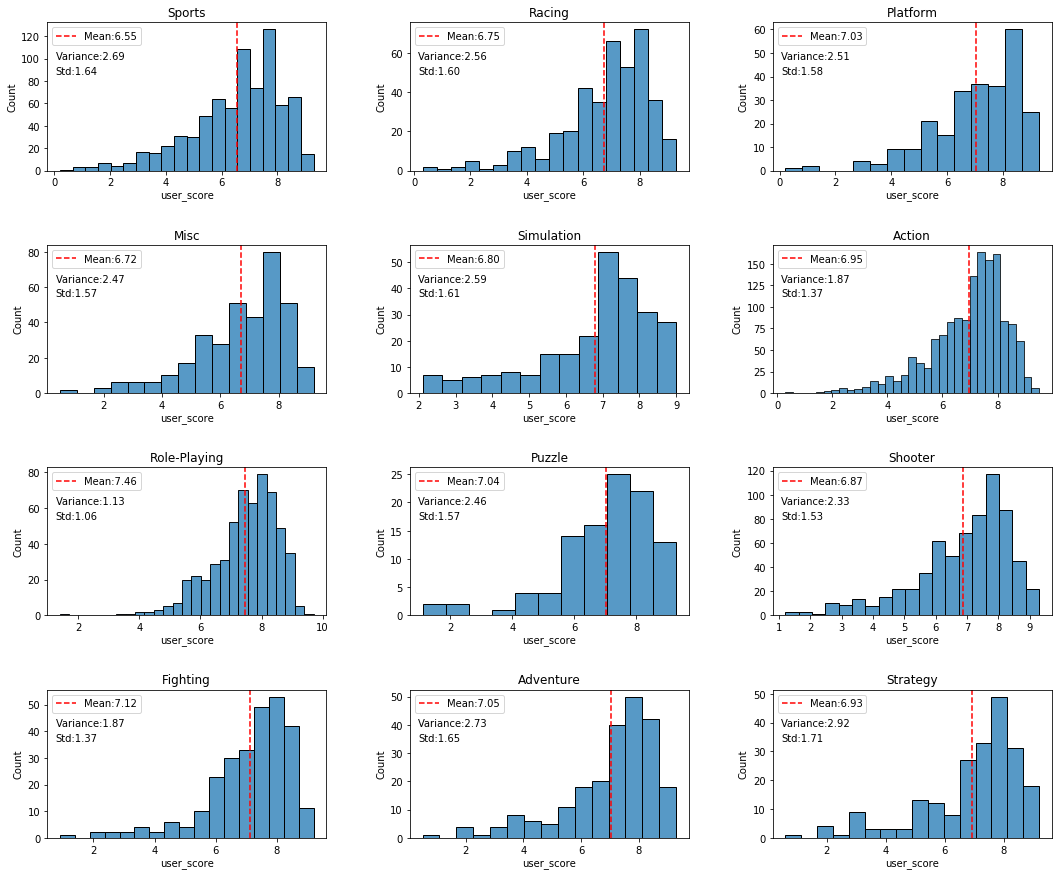

In [33]:
# distribution of user_score by genre
plt.figure(figsize=(18,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
r = 4  # rows
c = 3  # cols
n = 1  # plot num

for genre in genres: 
    user_score_data = data[(data['genre'] == genre) & (data['user_score'] > 0)]['user_score']
    mean = user_score_data.mean() 
    var = user_score_data.var()
    std = user_score_data.std()
    ax = plt.subplot(r, c, n)
    sns.histplot(x=user_score_data)
    ax.axvline(mean, color='r', linestyle='--')
    plt.title(genre)
    n += 1
    plt.legend({f'Mean:{mean:.2f}':mean})
    plt.text(0.03, 0.75, f'Variance:{var:.2f}', transform = plt.gca().transAxes)
    plt.text(0.03, 0.65, f'Std:{std:.2f}', transform = plt.gca().transAxes)

Распределение пользовательской оценки ассиметричное, высоких оценок заметно больше по всем жанрам, статистики отмечены на графиках

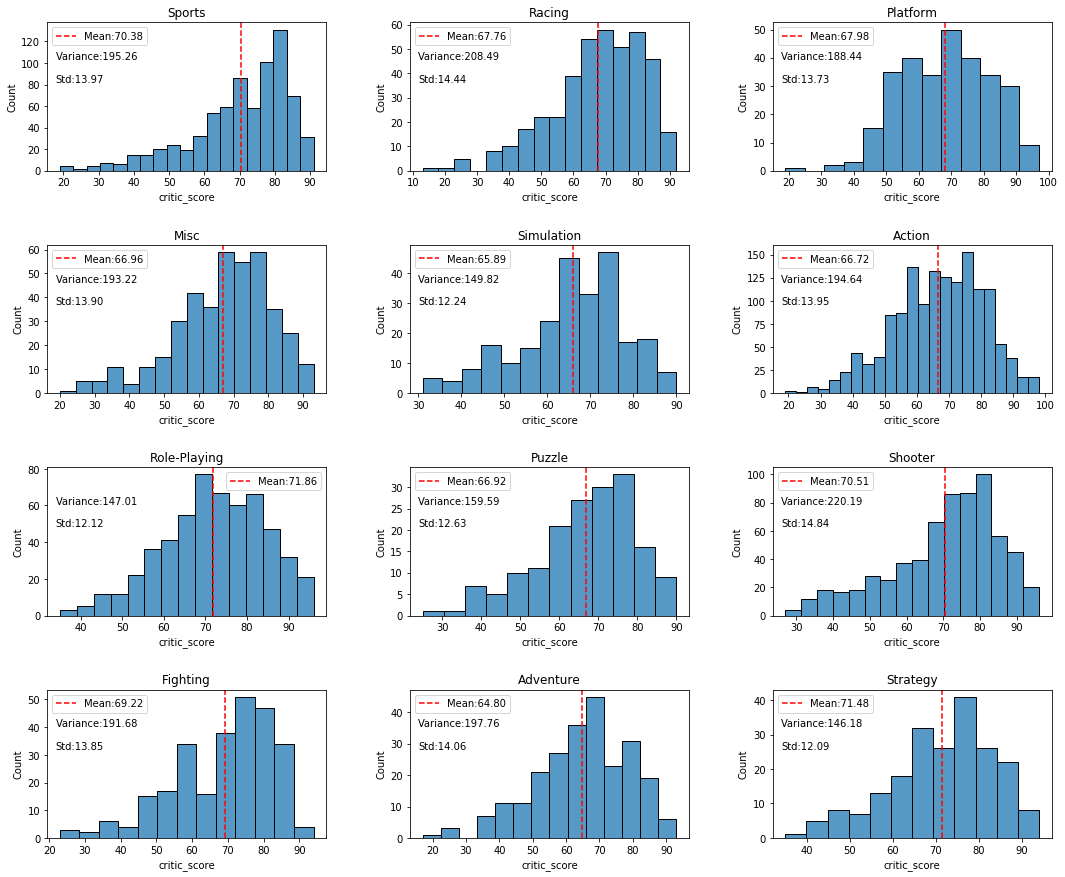

In [34]:
plt.figure(figsize=(18,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
a = 4  # rows
b = 3  # cols
c = 1  # plot counter

for genre in genres: 
    critic_score_data = data[(data['genre'] == genre) & (data['critic_score'] > 0)]['critic_score']
    mean = critic_score_data.mean() 
    var = critic_score_data.var()
    std = critic_score_data.std()
    ax = plt.subplot(a, b, c)
    sns.histplot(x=critic_score_data)
    ax.axvline(mean, color='r', linestyle='--')
    plt.title(genre)
    c += 1
    plt.legend({f'Mean:{mean:.2f}':mean})
    plt.text(0.03, 0.75, f'Variance:{var:.2f}', transform = plt.gca().transAxes)
    plt.text(0.03, 0.6, f'Std:{std:.2f}', transform = plt.gca().transAxes)

Распределение оценок критиков ближе к нормальному, чем пользовательские оценки, за исключением спортивного жанра(статистики указаны на графиках)

### Hypothesis testing

##### - Первая гипотеза
H0(null): Средние пользовательские рейтинги платформ Xbox One и PC одинаковые   
H1(alternative): Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые

Для теста гипотезы выбран t-test и сравнение p-value с пороговым значением alpha 0.05, за нулевую гипотезу принята гипотеза равенства.

In [35]:
# hypothesis testing

alpha = 0.05

xbox = data[(data['platform'] == 'XOne') & (data['user_score'] > 0)]['user_score']
pc = data[(data['platform'] == 'PC') & (data['user_score'] > 0)]['user_score']
results = ttest_ind(xbox, pc)

print(f'p-value {results.pvalue:.5f}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value 0.00346
Отвергаем нулевую гипотезу


Таким образом, средние пользовательские рейтинги платформ XBox One и PC не одинаковые.  


##### - Вторая гипотеза
H0: Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») не различаются.  
H Alternative: Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.  

Для теста гипотезы выбран t-test и сравнение p-value с пороговым значением alpha 0.05, за нулевую гипотезу принята гипотеза равенства.

In [36]:
# hypothesis testing

alpha = 0.05

act = data[(data['genre'] == 'Action') & (data['user_score'] > 0)]['user_score']
sport = data[(data['genre'] == 'Sports') & (data['user_score'] > 0)]['user_score']
results = ttest_ind(act, sport)

print(f'p-value {results.pvalue:.10f}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value 0.0000000010
Отвергаем нулевую гипотезу


Таким образом, средние пользовательские рейтинги жанров Action  и Sports различаются.

### Summary

По результатам проведенного анализа предоставленных данных можно сделать следующие выводы:
    1. Средняя продолжительность жизни игровой платформы около 10 лет, игровая индустрия зависима от технологического прогресса, поэтому платформы появляются и исчезают. Но в целом в последние годы наблюдается отрицательный тренд.  
    2. Пользовательские оценки весьма субъективны, что было визуализировано в большей склонности пользователей к высоким оценкам. Оценка критиков более сбалансирована и рейтинг критиков напрямую влияет на продажи.  
    3. Популярность игровых жанров зависит от культурных различий пользователей. Что наиболее ярко продемонстрировано на примере пристрастия Японцев к ролевым играм и значительных продаж игр с рейтингом T(teenagers).  
    4. Пользовательские рейтинги различны как по платформам, так и по жанрам(на примере двух выборок).